<h4><b>Machine Learning Project</b></h4>
<h4><b>Author : THAMBUGALA ATHUKORALALAGE JAYANI SANDUNKA ATHUKORALA</b></h4>

In [1]:
# This "project_file2.ipynb" file contains Stratified 5-fold cross-validation of CNN, LSTM, KNN models and Result visualization

<h3>Importing required Libraries</h3>

In [2]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from time import time
import matplotlib.pyplot as plt
import seaborn as sns #seaborn

# Import warnings filter
import warnings 
warnings.filterwarnings("ignore")

2023-06-11 01:27:51.388492: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 01:27:51.553792: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


<h3>Exploring the dataset</h3>

In [3]:
# Load FER2013 dataset
df = pd.read_csv('dataset/fer2013.csv')

<h3>Preprocess data</h3>

In [4]:
# Preprocess the data
X = []
y = []
for i, row in df.iterrows():
    pixels = np.array(row['pixels'].split(' '), dtype=int)
    X.append(pixels)
    y.append(row['emotion'])
X = np.array(X) / 255.0
y = np.array(y)

In [5]:
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprised', 'Neutral']

<h3>Define models</h3>

In [6]:
# CNN model
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(7, activation='softmax')
])

# LSTM model
lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(48, 48)),
    LSTM(64),
    Dense(7, activation='softmax')
])

# KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)

2023-06-11 01:28:17.300318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<h3>Stratified 5-fold cross-validation</h3>

<h4><b>Train and Evaluate CNN, LSTM, KNN models</b></h4>

In [7]:
# Stratified 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [8]:
# Initialize lists to store evaluation metrics
cnn_accuracies = []
cnn_f1_scores = []
cnn_training_times = []
cnn_prediction_times = []

lstm_accuracies = []
lstm_f1_scores = []
lstm_training_times = []
lstm_prediction_times = []

mlp_accuracies = []
mlp_f1_scores = []
mlp_training_times = []
mlp_prediction_times = []

knn_accuracies = []
knn_f1_scores = []
knn_training_times = []
knn_prediction_times = []

true_labels_list = []
cnn_predicted_labels_list = []
lstm_predicted_labels_list = []
knn_predicted_labels_list = []

In [9]:
# Iterate over cross-validation folds
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Reshape input data ------------------------------------------------------
    # Reshape input data for CNN model
    X_train_cnn = X_train.reshape(-1, 48, 48, 1)
    X_test_cnn = X_test.reshape(-1, 48, 48, 1)

    # Reshape input data for LSTM model
    X_train_lstm = pad_sequences(X_train.reshape(-1, 48, 48), maxlen=48, padding='post')
    X_test_lstm = pad_sequences(X_test.reshape(-1, 48, 48), maxlen=48, padding='post')

    # Normalize data for KNN models
    scaler = StandardScaler()
    X_train_knn = scaler.fit_transform(X_train)
    X_test_knn = scaler.transform(X_test)
    
    # Train and evaluate models------------------------------------------------
    
    # CNN model----------------------------------------------------------------
    # Train CNN model
    start_time = time()
    cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    cnn_model.fit(X_train_cnn, y_train, epochs=50, batch_size=64, verbose=1)
    cnn_training_time = time() - start_time
    
    # Predict CNN model
    start_time = time()
    cnn_predictions = cnn_model.predict(X_test_cnn)
    cnn_pred_time = time() - start_time
    
    # Calculate the accuracy of CNN model
    _, cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test)
    cnn_predictions = np.argmax(cnn_predictions, axis=1)
    cnn_f1 = f1_score(y_test, cnn_predictions, average='weighted')
    
    # Append the true and CNN predicted labels to the respective lists
    true_labels_list.append(y_test)
    cnn_predicted_labels_list.append(cnn_predictions)

    # LSTM model----------------------------------------------------------------
    # Train LSTM model
    start_time = time()
    lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=64, verbose=1)
    lstm_training_time = time() - start_time
    
    # Predict LSTM model
    start_time = time()
    lstm_predictions = np.argmax(lstm_model.predict(X_test_lstm), axis=-1)
    lstm_pred_time = time() - start_time
    
    # Calculate accuracy of LSTM model
    lstm_accuracy = accuracy_score(y_test, lstm_predictions)
    lstm_f1 = f1_score(y_test, lstm_predictions, average='macro')
    
    # Append the LSTM predicted labels to the respective lists
    lstm_predicted_labels_list.append(lstm_predictions)

    # KNN model----------------------------------------------------------------
    # Train KNN model
    start_time = time()
    knn_model.fit(X_train_knn, y_train)
    knn_training_time = time() - start_time
    
    start_time = time()
    knn_predictions = knn_model.predict(X_test_knn)
    knn_pred_time = time() - start_time
    
    knn_accuracy = accuracy_score(y_test, knn_predictions)
    knn_f1 = f1_score(y_test, knn_predictions, average='macro')
    
    # Append the KNNpredicted labels to the respective lists
    knn_predicted_labels_list.append(knn_predictions)

    # Append metrics to lists------------------------------------------------
    # Append CNN metrics to lists
    cnn_accuracies.append(cnn_accuracy)
    cnn_f1_scores.append(cnn_f1)
    cnn_training_times.append(cnn_training_time)
    cnn_prediction_times.append(cnn_pred_time)
   
    # Append LSTM metrics to lists
    lstm_accuracies.append(lstm_accuracy)
    lstm_f1_scores.append(lstm_f1)
    lstm_training_times.append(lstm_training_time)
    lstm_prediction_times.append(lstm_pred_time)
  
    # Append KNN metrics to lists
    knn_accuracies.append(knn_accuracy)
    knn_f1_scores.append(knn_f1)
    knn_training_times.append(knn_training_time)
    knn_prediction_times.append(knn_pred_time)    

Epoch 1/50
449/449 [==============================] - 39s 84ms/step - loss: 1.6766 - accuracy: 0.3350
Epoch 2/50
449/449 [==============================] - 37s 82ms/step - loss: 1.4355 - accuracy: 0.4557
Epoch 3/50
449/449 [==============================] - 36s 80ms/step - loss: 1.3408 - accuracy: 0.4920
Epoch 4/50
449/449 [==============================] - 34s 77ms/step - loss: 1.2755 - accuracy: 0.5164
Epoch 5/50
449/449 [==============================] - 34s 76ms/step - loss: 1.2144 - accuracy: 0.5437
Epoch 6/50
449/449 [==============================] - 34s 76ms/step - loss: 1.1659 - accuracy: 0.5630
Epoch 7/50
449/449 [==============================] - 34s 76ms/step - loss: 1.1079 - accuracy: 0.5855
Epoch 8/50
449/449 [==============================] - 34s 76ms/step - loss: 1.0575 - accuracy: 0.6077
Epoch 9/50
449/449 [==============================] - 34s 76ms/step - loss: 1.0081 - accuracy: 0.6285
Epoch 10/50
449/449 [==============================] - 34s 76ms/step - loss: 0.959

<h3>Result Summary</h3>

In [10]:
# Concatenate the true and predicted labels from all folds
true_labels = np.concatenate(true_labels_list)
cnn_predicted_labels = np.concatenate(cnn_predicted_labels_list)
lstm_predicted_labels = np.concatenate(lstm_predicted_labels_list)
knn_predicted_labels = np.concatenate(knn_predicted_labels_list)

<h4><b>CNN Model - Result Summary</b></h4>

In [11]:
# CNN confusion matrix report
print(classification_report(true_labels, cnn_predicted_labels, labels=[0,1,2,3,4,5,6], target_names=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprised', 'Neutral']))

              precision    recall  f1-score   support

       Angry       0.68      0.66      0.67      4953
     Disgust       0.69      0.67      0.68       547
        Fear       0.65      0.67      0.66      5121
       Happy       0.84      0.85      0.85      8989
         Sad       0.66      0.67      0.67      6077
   Surprised       0.83      0.81      0.82      4002
     Neutral       0.71      0.70      0.71      6198

    accuracy                           0.73     35887
   macro avg       0.72      0.72      0.72     35887
weighted avg       0.73      0.73      0.73     35887



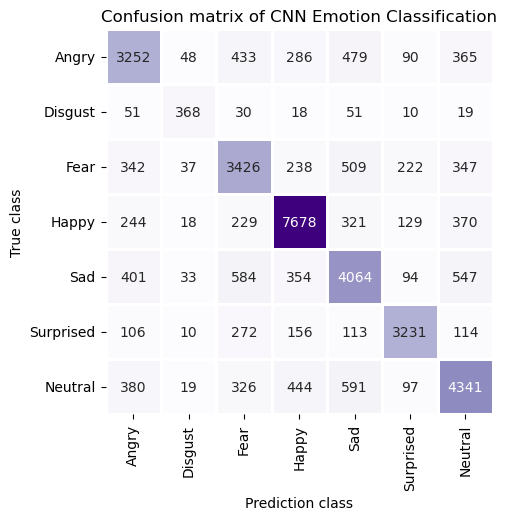

In [12]:
# Calculate CNN confusion matrix
cnn_cm = confusion_matrix(true_labels, cnn_predicted_labels)
#Transform to df for easier plotting
cnn_cm_df = pd.DataFrame(cnn_cm, index = labels, columns = labels)

plt.figure(figsize = (5,5))
sns.heatmap(cnn_cm_df, annot = True,cmap='Purples',cbar=False,linewidth=2,fmt='d')
plt.title('Confusion matrix of CNN Emotion Classification')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()

<h4><b>LSTM Model - Result Summary</b></h4>

In [13]:
# LSTM confusion matrix report
print(classification_report(true_labels, lstm_predicted_labels, labels=[0,1,2,3,4,5,6], target_names=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprised', 'Neutral']))

              precision    recall  f1-score   support

       Angry       0.56      0.17      0.27      4953
     Disgust       0.61      0.12      0.19       547
        Fear       0.56      0.18      0.27      5121
       Happy       0.29      0.88      0.43      8989
         Sad       0.47      0.10      0.17      6077
   Surprised       0.64      0.31      0.42      4002
     Neutral       0.47      0.13      0.20      6198

    accuracy                           0.35     35887
   macro avg       0.52      0.27      0.28     35887
weighted avg       0.47      0.35      0.30     35887



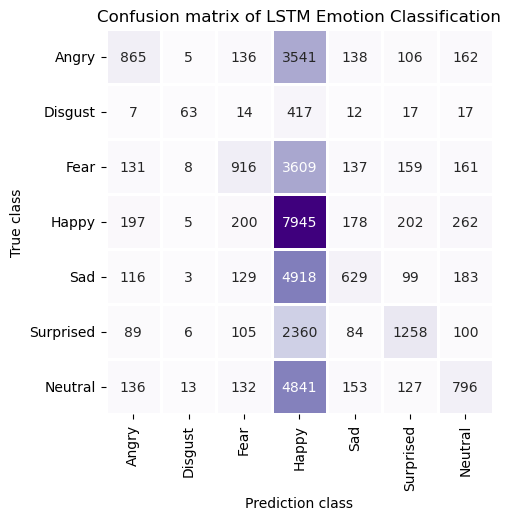

In [14]:
# LSTM Confusion matrix
lstm_cm = confusion_matrix(true_labels, lstm_predicted_labels)
#Transform to df for easier plotting
lstm_cm_df = pd.DataFrame(lstm_cm, index = labels, columns = labels)

plt.figure(figsize = (5,5))
sns.heatmap(lstm_cm_df, annot = True,cmap='Purples',cbar=False,linewidth=2,fmt='d')
plt.title('Confusion matrix of LSTM Emotion Classification')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()

<h4><b>KNN Model - Result Summary</b></h4>

In [15]:
# KNN confusion matrix report
print(classification_report(true_labels, knn_predicted_labels, labels=[0,1,2,3,4,5,6], target_names=['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprised', 'Neutral']))

              precision    recall  f1-score   support

       Angry       0.29      0.28      0.28      4953
     Disgust       0.25      0.36      0.30       547
        Fear       0.30      0.28      0.29      5121
       Happy       0.41      0.48      0.44      8989
         Sad       0.31      0.23      0.27      6077
   Surprised       0.52      0.40      0.45      4002
     Neutral       0.29      0.35      0.31      6198

    accuracy                           0.35     35887
   macro avg       0.34      0.34      0.33     35887
weighted avg       0.35      0.35      0.34     35887



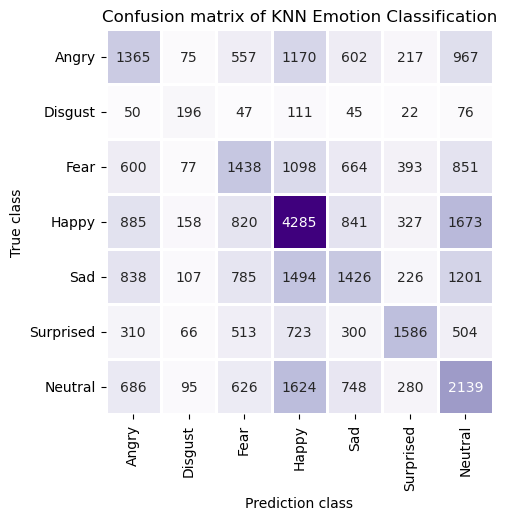

In [16]:
# KNN Confusion matrix
knn_cm = confusion_matrix(true_labels, knn_predicted_labels)
# Transform to df for easier plotting
knn_cm_df = pd.DataFrame(knn_cm, index = labels, columns = labels)

plt.figure(figsize = (5,5))
sns.heatmap(knn_cm_df, annot = True,cmap='Purples',cbar=False,linewidth=2,fmt='d')
plt.title('Confusion matrix of KNN Emotion Classification')
plt.ylabel('True class')
plt.xlabel('Prediction class')
plt.show()

<h4><b>Summary in total</b></h4>

In [17]:
# Print average performance metrics
print('CNN MODEL')
print('===========================================================')
print("Accuracy: {:.4f}".format(np.mean(cnn_accuracies)))
print('-----------------------------------------------------------')
print("F1-Score: {:.4f}".format(np.mean(cnn_f1_scores)))
print('-----------------------------------------------------------')
print("Average Training Time: {:.4f} s".format(np.mean(cnn_training_times)))
print('-----------------------------------------------------------')
print("Average Prediction Time: {:.4f} s".format(np.mean(cnn_prediction_times)))
print('-----------------------------------------------------------\n')

print('LSTM MODEL')
print('===========================================================')
print("Accuracy: {:.4f}".format(np.mean(lstm_accuracies)))
print('-----------------------------------------------------------')
print("F1-Score: {:.4f}".format(np.mean(lstm_f1_scores)))
print('-----------------------------------------------------------')
print("Average Training Time: {:.4f} s".format(np.mean(lstm_training_times)))
print('-----------------------------------------------------------')
print("Average Prediction Time: {:.4f} s".format(np.mean(lstm_prediction_times)))
print('-----------------------------------------------------------\n')

print('KNN MODEL')
print('===========================================================')
print("Accuracy: {:.4f}".format(np.mean(knn_accuracies)))
print('-----------------------------------------------------------')
print("F1-Score: {:.4f}".format(np.mean(knn_f1_scores)))
print('-----------------------------------------------------------')
print("Average Training Time: {:.4f} s".format(np.mean(knn_training_times)))
print('-----------------------------------------------------------')
print("Average Prediction Time: {:.4f} s".format(np.mean(knn_prediction_times)))

CNN MODEL
Accuracy: 0.7345
-----------------------------------------------------------
F1-Score: 0.7344
-----------------------------------------------------------
Average Training Time: 1715.9311 s
-----------------------------------------------------------
Average Prediction Time: 3.5875 s
-----------------------------------------------------------

LSTM MODEL
Accuracy: 0.3475
-----------------------------------------------------------
F1-Score: 0.2776
-----------------------------------------------------------
Average Training Time: 2307.9960 s
-----------------------------------------------------------
Average Prediction Time: 8.0619 s
-----------------------------------------------------------

KNN MODEL
Accuracy: 0.3465
-----------------------------------------------------------
F1-Score: 0.3341
-----------------------------------------------------------
Average Training Time: 0.0565 s
-----------------------------------------------------------
Average Prediction Time: 26.6832 s


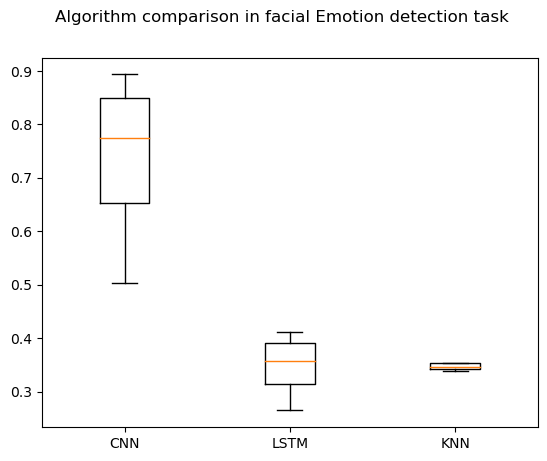

In [18]:
# Boxplot for algorithm comparison
names = ["CNN","LSTM", "KNN"]
accuracy_score = [cnn_accuracies, lstm_accuracies, knn_accuracies]
fig = plt.figure()
fig.suptitle('Algorithm comparison in facial Emotion detection task')
ax = fig.add_subplot(111)
plt.boxplot(accuracy_score)
ax.set_xticklabels(names)
plt.show()